Generating Fake audio using Encodec model

Extract discrete representations from the audio waveform

In [ ]:
from encodec import EncodecModel
from encodec.utils import convert_audio

import torchaudio
import torch

# Instantiate a pretrained EnCodec model
model = EncodecModel.encodec_model_24khz()
# The number of codebooks used will be determined bythe bandwidth selected.
# E.g. for a bandwidth of 6kbps, `n_q = 8` codebooks are used.
# Supported bandwidths are 1.5kbps (n_q = 2), 3 kbps (n_q = 4), 6 kbps (n_q = 8) and 12 kbps (n_q =16) and 24kbps (n_q=32).
# For the 48 kHz model, only 3, 6, 12, and 24 kbps are supported. The number
# of codebooks for each is half that of the 24 kHz model as the frame rate is twice as much.
model.set_target_bandwidth(6.0)

import os
current_dir = os.getcwd()

# audio file_path
file_path = os.path.join(current_dir, "sample_9.wav")

# Load and pre-process the audio waveform
wav, sr = torchaudio.load(file_path)
wav = convert_audio(wav, sr, model.sample_rate, model.channels)
wav = wav.unsqueeze(0)

# Extract discrete codes from EnCodec
with torch.no_grad():
    encoded_frames = model.encode(wav)
codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)  # [B, n_q, T]



/home/lekhab/.conda/envs/codec_fake/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [7]:
codes.shape

torch.Size([1, 8, 750])

In [ ]:
# Generate audio from codes
with torch.no_grad():
    audio_values = model.decode([(codes, None)])

# Convert the decoded audio tensor to numpy array
audio_values = audio_values.squeeze(0)  

# Save the decoded audio using torchaudio
torchaudio.save("encodec_decoded_audio.wav", audio_values.cpu(), model.sample_rate)



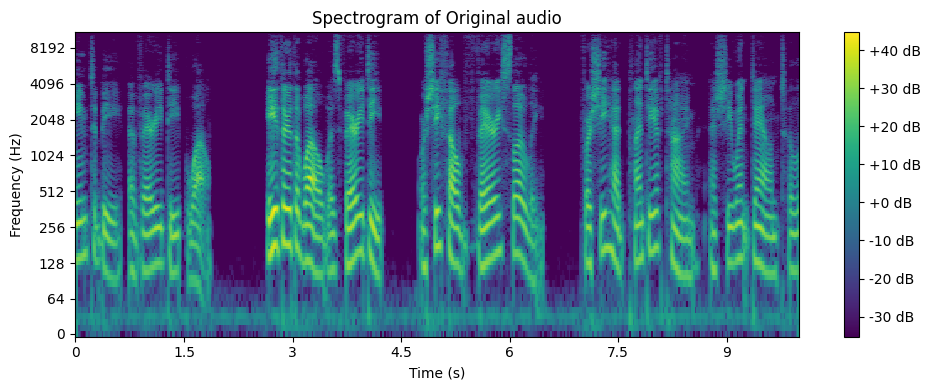

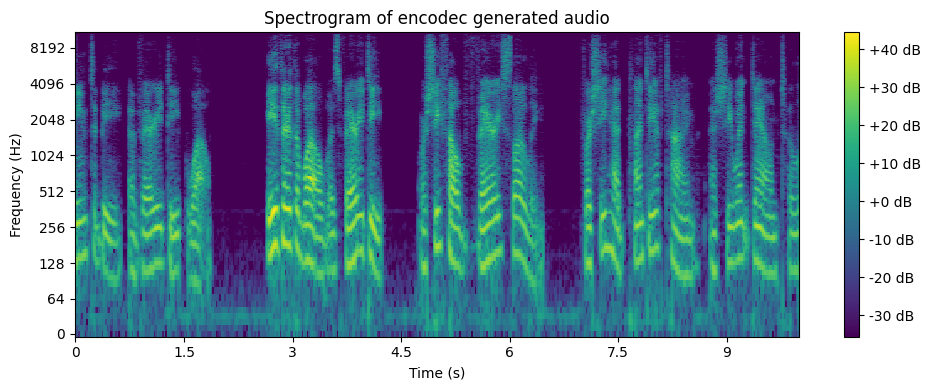

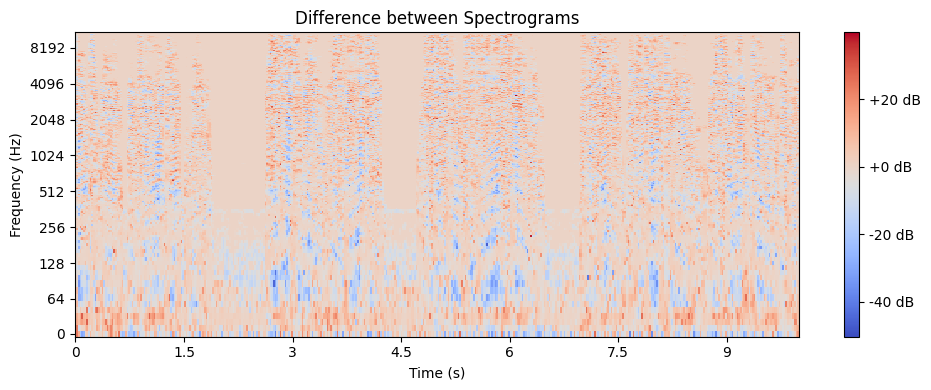

In [9]:
#Create spectograms for input and output audio files

import librosa
import librosa.display
import matplotlib.pyplot as plt

def plot_spectrogram(audio_file, title):
    # Load the audio file
    y, sr = librosa.load(audio_file)
    
    # Compute the STFT and convert to decibel scale
    stft = librosa.stft(y)
    spectrogram = librosa.amplitude_to_db(abs(stft))
    
    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()



def plot_spectrogram_difference(audio_file1, audio_file2):
    # Load and compute spectrograms for both audio files
    y1, sr1 = librosa.load(audio_file1)
    y2, sr2 = librosa.load(audio_file2)
    
    if sr1 != sr2:
        raise ValueError("Sample rates of the two audio files do not match. Please resample to the same rate.")
    
    # Compute the STFT for both signals
    stft1 = librosa.stft(y1)
    stft2 = librosa.stft(y2)
    
    # Convert to decibel scale
    spectrogram1 = librosa.amplitude_to_db(abs(stft1))
    spectrogram2 = librosa.amplitude_to_db(abs(stft2))
    
    # Compute the difference between the two spectrograms
    spectrogram_diff = spectrogram1 - spectrogram2
    
    # Plot the difference
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_diff, sr=sr1, x_axis='time', y_axis='log', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Difference between Spectrograms")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()
# File paths for the two audio files
audio_file1 = 'sample_9.wav'  # original audio
audio_file2 = 'encodec_decoded_audio.wav'  # output audio file from dac

# Plot spectrograms for both files
plot_spectrogram(audio_file1, title="Spectrogram of Original audio")
plot_spectrogram(audio_file2, title="Spectrogram of encodec generated audio")
plot_spectrogram_difference(audio_file1, audio_file2)
